# Hex Tiled Q-Learning SAR example

The challenge in this example is implementing a Q-Learning search algorithm in a hexagonal tiled environment

In [1]:
# Setup
import sys, os
from loguru import logger

sys.path.insert(0, os.path.join(os.getcwd(), "../src")) # run from within examples folder

logger.remove()
logger.add(sys.stderr, level="INFO")

BUILD: str = os.environ.get("BUILD", "")
num_trials: int
steps: int
if BUILD == "doctest": # tox env specific to doctests
    num_trials = 1
    steps = 5
elif BUILD == "html": # tox env specific to building docs
    num_trials = 30000
    steps = 20
else: # normal operation
    num_trials = 500000
    steps = 200 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import copy
from tqdm.notebook import tqdm
import tempfile
import csv

In [3]:
from jsim.Environment import HexEnvironment, HexDirections
from jsim.Agent import Agent
from jsim.Simulation import Simulation
from jsim.Environment.HexEnvironment.HexCoords import OffsetCoord

In [4]:
class QHexEnv(HexEnvironment):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.pdm = self._generate_pdm()
        self.n_bins = 4
        self.digitized_pdm = self._encode_pdm(n=self.n_bins)
        self._digitized_pdm_store = np.copy(self.digitized_pdm)

        self._encode_penalty()

        self._generate_states()

    def _generate_pdm(self, N:int=5):
        self._shape = (self._shape[0]+2, self._shape[1]+2)

        x, y = np.meshgrid(np.arange(self.shape[0]), np.arange(self.shape[1]))

        pdm = np.zeros(self.shape) # pad the PDM with zeros on all sides

        for _ in range(N): # Generate N gaussians
            A = max(np.random.rand()*2,1)
            a = np.random.rand()*0.03
            b = 0
            c = np.random.rand()*0.03
            x0 = np.random.uniform(0,self.shape[0]) # Centre of gaussian
            y0 = np.random.uniform(0,self.shape[1])

            pdm += A*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))

        return pdm

    def _encode_penalty(self):
        penalty = -1
        self.pdm[0,:] = penalty 
        self.pdm[-1,:] = penalty
        self.pdm[:,0] = penalty
        self.pdm[:,-1] = penalty

        self.digitized_pdm[0,:] = -1 
        self.digitized_pdm[-1,:] = -1
        self.digitized_pdm[:,0] = -1
        self.digitized_pdm[:,-1] = -1

    def _encode_pdm(self, n: int) -> np.ndarray:
        n_bins = n
        bins = np.arange(0,np.max(self.pdm), np.max(self.pdm)/n_bins)
        return np.digitize(self.pdm, bins)

    def _generate_states(self) -> None:
        c = np.arange(-1,1+np.max(self.digitized_pdm))
        dirs = np.array([f.flatten() for f in np.meshgrid(c,c,c,c,c,c)])
        pstates = np.unique(dirs,axis=1)
        i = -1
        self.possible_states = {(a,b,c,d,e,f): (i:=i+1) for a,b,c,d,e,f in pstates.transpose()}

        # Old method, used as a warning against not using numpy for everything
        # This would take about 7s to run. The above method takes about 0.2s
        #
        # c = np.arange(-1,1+np.max(self.digitized_pdm))
        # u,v,w,x,y,z = np.meshgrid(c,c,c,c,c,c) # one for each direction (6)
        # u,v,w,x,y,z = u.flatten(), v.flatten(), w.flatten(), x.flatten(), y.flatten(), z.flatten()
        # self.possible_states = {(a,b,c,d,e,f): int(np.where((u==a)&(v==b)&(w==c)&(x==d)&(y==e)&(z==f))[0]) for a,b,c,d,e,f in zip(u,v,w,x,y,z)}


    def _state_from_list(self, l):
        assert len(l) == len(HexDirections)
        return self.possible_states[tuple(l)]

    def _evaluate_digi_position(self, pos: OffsetCoord) -> int:
        return self.digitized_pdm[pos.row, pos.col]
    
    def _evaluate_position(self, pos: OffsetCoord) -> float:
        return self.pdm[pos.row, pos.col]

    def reset(self, agent_p: OffsetCoord) -> int:
        self.digitized_pdm = np.copy(self._digitized_pdm_store)
        return self._evaluate_digi_position(agent_p)

    def step(self, agent_s: OffsetCoord) -> tuple[int, float]:
        reward = self._evaluate_position(agent_s)
        neighbors = self.neighbors_coord(agent_s)

        values_at_neighbors = self._state_from_list([self._evaluate_digi_position(n) for n in neighbors])

        self.digitized_pdm[agent_s.row][agent_s.col] = -1

        return values_at_neighbors, reward

In [5]:
class QAgent(Agent):
    def __init__(self, penv: QHexEnv = None) -> None:
        self.state = OffsetCoord(col=0,row=0)
        self.states = []
        self.penv = penv

        self.epsilon = 1
        self.qtable = np.zeros((len(self.penv.possible_states),6))

    def policy(self, pnext_s: int) -> HexDirections:
        epsilon = 0.2
        result = None

        if np.random.uniform(0,1) < epsilon:
            idx = np.random.randint(0,6)
        else:
            idx = np.argmax(self.qtable[pnext_s])
        result = HexDirections(idx)
        return result

    def step(self, pnext_s: int) -> HexDirections:
        return self.policy(pnext_s)

    def learn(self, reward: float, state: int, next_state: int,  action: HexDirections) -> None:
        """
        Maximize the reward through a Q-Learning Step

        :param reward: Reward based on the probability seen from the previous action by the agent
        :type reward: float
        :param state: The state of the digitized PDM around the agent when the previous action was deciced
        :type state: int
        :param next_state: The new state that the agent is in
        :type next_state: int
        :param action: The action by the agent
        :type action: HexDirections
        """
        alpha = 0.01
        gamma = 0.99

        reward *= -1

        new_value = (1 - alpha) * self.qtable[state,action] + alpha * (reward+gamma*np.max(self.qtable[next_state]))

        self.qtable[state][action] = new_value


    def update(self, pa: HexDirections) -> OffsetCoord:
        if not hasattr(self,'state'):
            logger.error(f"Reset has not been called as {hasattr(self,'state')=}")
            raise Exception

        next_state = QHexEnv.neighbor_coord(self.state, pa)
        self.state = next_state

        return copy(self.state)

    def reset(self, ps: OffsetCoord, vicinity: int) -> tuple[HexDirections, OffsetCoord]:
        self.epsilon = np.max([0.01,self.epsilon*0.99])
        self.state = copy(ps)
        return self.policy(vicinity), self.state

In [6]:
class QSim(Simulation):
    agent: QAgent
    env: QHexEnv

    def __init__(self, initial_pos=OffsetCoord(col=5,row=5)) -> None:
        self.env = QHexEnv(psim=self)
        self.agent = QAgent(penv=self.env)

        self.initial_agent_s = initial_pos

        self.data_store = {'env_s':[],'agent_s':[],'agent_a':[],'reward':[]}
        self.long_term_file_handle = tempfile.mkstemp(
            suffix='.csv',
            text=True
        )
        self.long_term_file = open(self.long_term_file_handle[1],'w')
        self.long_term_file_writer = csv.writer(self.long_term_file)

        self.best_run = {'total_reward':-np.inf}

        super().__init__()

    def __del__(self):
        os.close(self.long_term_file_handle[0])

    def reset(self) -> None:
        self.vicinity_pdm = self.env.reset(self.initial_agent_s)
        self.agent_a, self.agent_s = self.agent.reset(copy(self.initial_agent_s),self.vicinity_pdm)
        self.data_store = {'env_s':[],'agent_s':[],'agent_a':[],'reward':[]}

    def trials(self, num_trials: int, max_num_steps: int):
        for i in tqdm(range(num_trials),):
            try:
                self.steps(max_num_steps)
                logger.debug(f"Trial = {i}/{num_trials} | Max number of steps ({max_num_steps}) reached ")
            except IndexError as e:
                logger.debug(f"Trial = {i}/{num_trials} | Agent went out of bounds, resetting")
            finally:
                self.data_store['total_reward'] = np.sum(self.data_store['reward'])
                logger.debug(f"Trial = {i}/{num_trials} | Total reward = {self.data_store['total_reward']:.2f}")
                
                # trim the data a bit to save memory
                self.data_store.pop("agent_a",None)
                self.data_store.pop("env_s",None)
                self.data_store.pop("reward",None)

                if self.data_store['total_reward'] > self.best_run['total_reward']:
                    self.data_store['epoch'] = i
                    self.best_run = copy(self.data_store)

                self.long_term_file_writer.writerow([i, self.data_store['total_reward']])

    def steps(self, num_steps: int) -> None:
        self.reset()
        
        agent_s = self.agent_s
        for _ in range(num_steps):
            vicinity_pdm, reward = self.env.step(self.agent_s)

            self.collect_data(vicinity_pdm, self.agent_a, self.agent_s, reward)

            agent_a = self.agent.step(vicinity_pdm)

            if agent_s and (agent_s.row > 0 or \
                    agent_s.col > 0 or \
                    agent_s.row < self.env.shape[0] or \
                    agent_s.col < self.env.shape[1]):

                agent_s = self.agent.update(agent_a)

            if agent_s.row < 0 or agent_s.col < 0:
                raise IndexError(f"Out of bounds with {agent_s} < 0")
            if agent_s.row > self.env.shape[0] or agent_s.col > self.env.shape[1]:
                raise IndexError(f"Out of bounds with {agent_s} > {self.env.shape}")

            self.agent.learn(reward, self.vicinity_pdm, vicinity_pdm, agent_a)

            self.agent_s = agent_s
            self.agent_a = agent_a
            self.vicinity_pdm = vicinity_pdm


    def collect_data(self, env_s: int, agent_a: HexDirections, agent_s: OffsetCoord, reward: float) -> None:
        self.data_store['env_s'].append(copy(env_s))
        self.data_store['agent_a'].append(copy(agent_a))
        self.data_store['agent_s'].append(copy(agent_s))
        self.data_store['reward'].append(copy(reward))


In [7]:
def plot(sim: QSim):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8, 6), dpi=80)

    data = []
    sim.long_term_file.close()
    with open(sim.long_term_file_handle[1],'r') as f:
        reader = csv.reader(f)
        for row in reader:
            data.append([float(f) for f in row])
    data = np.array(data)

    t = np.arange(0,len(data))

    # Reward over time
    ax1.plot(data[:,0], data[:,1])
    ax1.set_ylabel('Total reward')
    ax1.set_xlabel('Epoch')

    # Show pdm and path
    best_ds = sim.best_run
    xy = [HexEnvironment.offset_to_pixel(f) for f in best_ds['agent_s']]
    x = [f.x for f in xy]
    y = [f.y for f in xy]

    for p in sim.env.as_mpl_polygons(cmap=mpl.cm.get_cmap('gray')):
        ax2.add_patch(p)

    ax2.plot(x,y)
    ax2.scatter(x[0],y[0],label='Start')
    ax2.scatter(x[-1],y[-1],label='End')
    ax2.set_ylabel('y')
    ax2.set_xlabel('x')
    ax2.set_title(f'Best run at n={best_ds["epoch"]}\nReward={best_ds["total_reward"]:.2f}')
    ax2.legend()
    ax2.set_aspect('equal')
    fig.tight_layout()
    
    logger.info(f"Number of steps: {steps}")
    logger.info(f"Number of trials: {num_trials}")
    plt.show()

In [8]:
# Learn
sim = QSim()

sim.trials(num_trials,steps)

  0%|          | 0/100000 [00:00<?, ?it/s]

2022-02-02 10:01:16.390 | INFO     | __main__:plot:38 - Number of steps: 200
2022-02-02 10:01:16.391 | INFO     | __main__:plot:39 - Number of trials: 100000


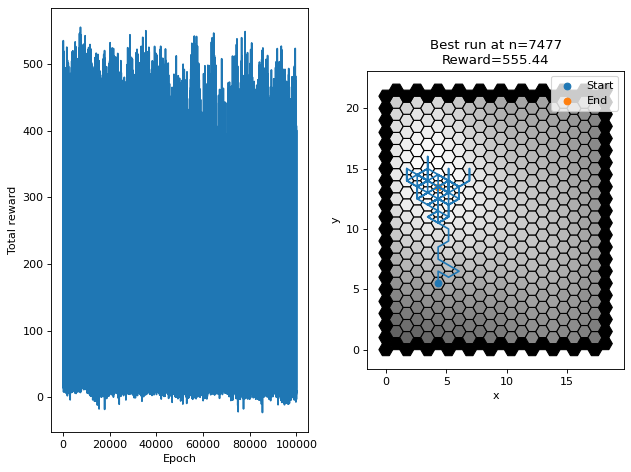

In [9]:
plot(sim)